# Nifty 50 Partial Replication 
Index funds have become a household occurence in the financial sphere, especially for retail investors, due to their simplicity, diversification and low cost compared to actively managed funds. Following an index can be done in one of two ways:
- **Full replication:** The most common approach, where a fund holds all constituent stocks present in the index, with the same weights as the index.
- **Partial Replication:** With this approach, only a subset of the index's constituents is selected, which should aim to approximate the overall index performance.

Partial replication can offer a number of benefits over full replication, but mainly:
- Lower transaction costs: Reducing the number of stocks traded minimizes fees such as brokerage fees.
- Reduced Trading fees: By potentially avoiding low-liquidity stocks, we avoid have wider bid-ask spreads, as well as having less market impact.
- Higher flexibility: Funds can add other constraints on top of avoiding low-liquidity stocks, such as those on sectors or specific stocks, giving them better control over their risk management.
Our project's goal is to apply supervised learning techniques to develop a partial replication strategy, minimizing the tracking error of our portfolio.

## Methodology
The project will focus on the NIFTY 100 index, which includes the top 100 companies in the National Stock Exchange of India (NSE) based on market capitalization. 

We will begin by gathering the minute-level data for both the index as well as the constituents data. Combining the data into a single dataframe, and perform some basic cleaning tasks, removing certain columns with a large number of empty values, as well as rows without target value, etc. Our target variable will be the **NIFTY 100 index price**.

Since our goal is to reduce the number of constituents to use only a subset of the total 100 stocks, our models will follow a 2 step approach:
1. Feature Selection: We will first apply different feature selection techniques, (Lasso regression, Correlation matrix, Mutual information) to identify the most relevant stocks for our model.
2. Model Training: Once the most relevant features (stocks) are selected, we will train different supervised learning models on the reduced dataset, these models will predict the weights for each of the relevant stocks.
To ensure the robustness of the test results, while accounting for the nature of the data (ordered time series) we will use a **sliding window approach**, where:
* A fixed-size window (roughly 1-year) is used to train the model.
* The model will be tested on roughly the next 3 months.
* The window will slide forward, repeating until we use all available data.

For a certain model, the overall out-of-sample error will be the average error over all the windows. The error we will aim to minimize is the **tracking error**, for simplicity models will minimize MSE. Finally, we will compare models by plotting the error vs the number of stocks, to visualize how it evolves as we reduce the size of the subset of constituents chosen.



In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import cross_val_score, TimeSeriesSplit, ParameterGrid
from sklearn.linear_model import LassoCV
import matplotlib.pyplot as plt
import os
import glob
from tqdm import tqdm
import warnings
from sklearn.ensemble import RandomForestRegressor
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore")
warnings.filterwarnings("always", category=ConvergenceWarning)
import seaborn as sns
from sklearn.pipeline import Pipeline
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import xgboost as xgb
from sklearn.feature_selection import SelectFromModel,mutual_info_regression

## Tracking Error
Tracking error is the metric most commonly used to judge how well a replicating portfolio tracks the benchmark index, for full replication we would expect this to be close to 0 (slightly higher than 0 due to transaction costs or rebalancing delays).

The tracking error is defined as the standard deviation of the differences between the index and replicating portfolio over a specified time period.

$$
\text{Tracking Error} = \sqrt{\frac{\sum_{t=1}^T \left( R_{portfolio}(t) - R_{index}(t) \right)^2}{T}}
$$

Where: 
*  $R_{portfolio}(t)$ is the portfolio return at time $t$,  
*  $R_{index}(t)$ is the index's return at time $t$,  
*  $T$  is the total number of time periods.

We base ourselves on this metric, and add a small adjustment, where from the first return of the portfolio, the trading cost is subtracted, this is a simulated trading cost, which we will simply set to 0.2%.

In [2]:
def tracking_error(y_true, y_pred):

    # Convert y_true and y_pred to pandas Series for easy handling of pct_change()
    y_true = pd.Series(y_true)
    y_pred = pd.Series(y_pred)
    
    # Calculate the difference between the percentage changes
    diff_pct_change = y_true - y_pred    

    # Return the standard deviation of the differences (tracking error)
    return np.std(diff_pct_change.dropna())  # dropna() to avoid NaN values in pct_change

In [3]:
def adj_tracking_error(y_true, X_test, model):
    cost = 0.002  # 0.1% cost
    X_test_adjusted = X_test.copy()
    X_test_adjusted[0, :] -= cost  # Subtract cost from the first return of each stock

    # Predict with adjustment
    y_pred_adjusted = model.predict(X_test_adjusted)
    return tracking_error(y_true, y_pred_adjusted)

# Data
The data for this project will be taken from 2 Kaggle datasets:

* [Nifty 100 Constituents](https://www.kaggle.com/datasets/debashis74017/stock-market-data-nifty-50-stocks-1-min-data): This data set will be used to gather price data for all constituents for the NIFTY 100 index. The dataset contains a file per stock, which contains OHLC (Open, High, Low, Close) as well as Volume data.
* [Nifty 100 Index Data](https://www.kaggle.com/datasets/debashis74017/nifty-50-minute-data): This data set will be used to get the price data for the NIFTY 100 index price.

In order to speed up the execution, an intermediate dataset is created where we keep only closing prices for all stocks, in one single file. This dataset is [Nifty 100 Closing Only Data](https://www.kaggle.com/datasets/danielbrito99/nifty-50-closing-data). The script used to extract this intermediate data, is described in the cell below.

As was mentioned before our target variable will be the **NIFTY 100 Index Price**, by training the model with a reduced number of constituents to predict the index price based on that reduced subset, we will obtain weights for each of them. During the testing phase, we will use these weights to evaluate the model's performance and verify how well the selected subset mimics the index price. 

directory_path = '/kaggle/input/stock-market-data-nifty-50-stocks-1-min-data'
pattern = os.path.join(directory_path, "*.csv")  # Change "*.csv" to match other patterns if needed
Get the list of files that match the pattern
file_list = glob.glob(pattern)

def fetch_data(cols, file_list):
    df_list = []
    for file in tqdm(file_list):
        stock_name = os.path.basename(file).split("_")[0]
        file_df = pd.read_csv(file, index_col=0)
        file_df = file_df[[cols]]
        file_df.columns = pd.MultiIndex.from_product([[stock_name], file_df.columns])
        df_list.append(file_df)
    return pd.concat(df_list, axis=1)

df = fetch_data('close')
df.to_csv('/kaggle/input/nifty_50_closing.csv')

In [4]:
df = pd.read_csv('/kaggle/input/nifty-50-closing-data/nifty_50_closing.csv', index_col=0, header=[0, 1])
df = df.xs('close', level=1, axis=1)
df.index = pd.to_datetime(df.index)
nan_rows = df.isna().any(axis=1)

# Get the number of rows with NaN value
num_nan_rows = nan_rows.sum()


print(f"Number of rows with NaN values: {num_nan_rows}")

nifty_100_closing = pd.read_csv('/kaggle/input/nifty-50-minute-data/NIFTY 100_minute.csv', index_col=0)[['close']]
nifty_100_closing.index = pd.to_datetime(nifty_100_closing.index)
nifty_100_closing.rename(columns={'close': 'NIFTY_100'}, inplace=True)

Number of rows with NaN values: 639555


## Data Cleaning
Our data cleaning will be simple, we will focus on remediating the high number of NaN's present in the dataset.
Most importantly, we will focus on sequences of NaN values, which are problematic for our problem, as conventional techniques such as forward fill or interpolation become less effective the longer the period of missing data. Conversely, sparse or isolated NaNs are less of an issue, as they can be effectively substituted using these techniques with minimal loss of information. 


With this in mind, we perform the following steps:

* Remove NIFTY 50 and NIFTY BANK stocks, as they represent indices, not stocks.
* To get rid of periods where a large number of stocks all are missing data, we remove the rows with higher than 25 NaNs.
* Inspecting the longest NaN period for each column, we will get rid of those columns where the value is large:
    * HDFCAMC
    * ICICIPRULI
    * HDFCLIFE
    * GLAND
    * ADANIGREEN
    * DMART
    * ICICIGI
    * BANDHANBNK
    * INDIGO
    * SBILIFE
    * LICI
    * SBICARD
    * LTI
*  At this point the number of NaN rows and consecutive NaNs is much lower, so we can use forward fill to populate them with the last know values.

In [5]:
def longest_nan_period(series):
    max_nan_period = 0
    current_nan_period = 0
    for value in series:
        if pd.isna(value):
            current_nan_period += 1
            max_nan_period = max(max_nan_period, current_nan_period)
        else:
            current_nan_period = 0
    return max_nan_period

In [6]:
df

,HDFCAMC,APOLLOHOSP,BOSCHLTD,INDUSTOWER,BERGEPAINT,MARICO,ICICIPRULI,HDFCLIFE,SBIN,SUNPHARMA,...,SBICARD,DABUR,SAIL,BRITANNIA,ADANIPORTS,ONGC,EICHERMOT,TECHM,JINDALSTEL,HEROMOTOCO
date,,,,,,,,,,,,,,,,,,,,,
2018-08-06 10:47:00+05:30,1803.95,974.30,19187.45,290.0,316.85,357.95,408.50,485.00,306.70,579.65,...,NaN,435.30,79.35,3194.92,400.70,167.75,2711.30,670.45,207.65,3259.00
2018-08-06 10:48:00+05:30,1803.90,973.70,19187.45,290.0,316.50,357.55,408.10,484.95,306.70,579.30,...,NaN,435.15,79.30,3193.02,400.55,167.55,2710.60,670.55,207.80,3260.60
2018-08-06 10:49:00+05:30,1806.00,973.70,19187.45,290.0,316.85,357.20,408.85,485.00,306.75,579.45,...,NaN,435.70,79.30,3192.50,400.30,167.55,2709.80,670.65,207.55,3259.50
2018-08-06 10:50:00+05:30,1806.35,974.00,19174.90,290.0,316.80,357.65,408.90,484.10,306.75,578.10,...,NaN,435.65,79.30,3192.67,399.80,167.50,2708.05,670.90,207.90,3258.50
2018-08-06 10:51:00+05:30,1809.00,975.15,19190.00,290.0,316.80,357.75,408.85,484.20,306.85,578.50,...,NaN,436.00,79.30,3194.02,400.30,167.40,2709.95,671.20,207.80,3258.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-25 12:27:00+05:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2589.95
2022-10-25 12:28:00+05:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2589.30
2022-10-25 12:29:00+05:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2590.20


In [7]:
df.drop(columns=['NIFTY 50', 'NIFTY BANK'], inplace=True)

In [8]:
# Removing rows with more than 25 stocks without data
nan_counts = df.isna().sum(axis=1)
df = df[nan_counts <= 25]

In [9]:
# Now we observe per column, the longest period with NaN values
longest_nan_periods = {column: longest_nan_period(df[column]) for column in df.columns}

# Print the longest NaN period for each column
for column, period in longest_nan_periods.items():
    print(f"Longest period of NaN values in column {column}: {period} periods")

Longest period of NaN values in column HDFCAMC: 305198 periods
Longest period of NaN values in column APOLLOHOSP: 1 periods
Longest period of NaN values in column BOSCHLTD: 3 periods
Longest period of NaN values in column INDUSTOWER: 1 periods
Longest period of NaN values in column BERGEPAINT: 1 periods
Longest period of NaN values in column MARICO: 0 periods
Longest period of NaN values in column ICICIPRULI: 144000 periods
Longest period of NaN values in column HDFCLIFE: 242175 periods
Longest period of NaN values in column SBIN: 0 periods
Longest period of NaN values in column SUNPHARMA: 0 periods
Longest period of NaN values in column COALINDIA: 0 periods
Longest period of NaN values in column WIPRO: 1 periods
Longest period of NaN values in column BAJAJ-AUTO: 1 periods
Longest period of NaN values in column GODREJCP: 1 periods
Longest period of NaN values in column UPL: 0 periods
Longest period of NaN values in column SIEMENS: 0 periods
Longest period of NaN values in column BPCL: 

In [10]:
df.drop(columns=['HDFCAMC', 'ICICIPRULI', 'HDFCLIFE', 'GLAND', 'ADANIGREEN', 'LTI', 'SBICARD',
                 'DMART','ICICIGI','BANDHANBNK','INDIGO','SBILIFE','LICI'], inplace=True)

In [11]:
# Get the number of rows with NaN values
nan_rows = df.isna().any(axis=1)
num_nan_rows = nan_rows.sum()
print(f"Number of rows with NaN values: {num_nan_rows}")

Number of rows with NaN values: 30836


In [12]:

# Drop rows that still have NaNs in place
df.dropna(inplace=True)

In [13]:
df.index = df.index.tz_localize(None)
df_total = df.join(nifty_100_closing, how='left')

In [14]:
df_total.dropna(inplace=True)

In [15]:
# Calculate the percentage change
X_pct_change = df_total.pct_change()

# Define the threshold for large changes (e.g., 100% change)
threshold = 1.0  # 1.0 corresponds to 100% when working with pct_change()

# Find rows with any column having a percentage change greater than the threshold
large_change_rows = X_pct_change[(X_pct_change.abs() > threshold).any(axis=1)]

# Get the number of rows where there are large percentage changes
num_large_changes = large_change_rows.shape[0]

print(f"Number of rows with large changes (>{threshold * 100}%): {num_large_changes}")

Number of rows with large changes (>100.0%): 42


In [16]:
print(len(df_total))

629791


In [17]:
df_total.sort_index(inplace=True)

# Models

Firstly, let's explain the general architecture of the model, firstly, we must understand the pitfalls of using time series data, and how it affects our choice of cross validation strategy. Since the order of data must be preserved, we cannot use a conventional cross validation, and rather opt for a TimeSeriesSplit, specifically, we set the training and test sizes of the window, to get the desired sliding window result, where the training window is roughly 1 year, and the testing widnow around 3 months, this yields a total of 18 windows.

Knowing this, we propose the following general architecture, for a given model and threshold:

For each fold:

1. Perform feature selection (ex: Lasso with high alpha, Dropping Correlated variables, Mutual Information) using the threshold.
2. Train model on reduced feature space, with hyperparameter tuning to choose best parameters.
3. Save the tracking error and number of features (stocks) used in training

Finally, we return the following averages over the folds
* Average number of stocks.
* Average tracking error.

We will observe how different models (LinearRegression, ElasticNet, XGBRegressor and RandomForestRegressor) produce predictions and produce a plot for the average tracking error against the average number of stocks.

## Correlation - Lasso

In [18]:
def remove_correlated_features(X_train, threshold):
    X_train = pd.DataFrame(X_train)
    
    # Compute the correlation matrix (absolute values)
    corr_matrix = X_train.corr().abs()
    
    # Create a mask to select only the upper triangle of the correlation matrix
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Find features with correlation greater than the threshold
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]
    print(f"Features to drop (correlation > {threshold}): {to_drop}")
    selected_features = [i for i in range(X_train.shape[1]) if i not in to_drop]
    
    return selected_features
    

In [19]:
from sklearn.preprocessing import StandardScaler


def Corr_Lasso(threshold, X, y, debug=False):
    tscv = TimeSeriesSplit(n_splits=13, max_train_size=85000, test_size=45000)
    stocks = []
    num_stocks = []
    fold_scores = []
    adj_fold_scores = []

    for train_index, test_index in tscv.split(X):
        X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
        y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_train_cv)

        # Feature selection using correlation matrix
        selected_indices = remove_correlated_features(X_scaled, threshold)

        X_train_selected = X_scaled[:, selected_indices]
        X_test_selected = X_test_cv.to_numpy()[:, selected_indices]
        if debug == True:
            print(f"Selected {len(selected_indices)} stocks")
        num_stocks.append(len(selected_indices))
        stocks.append(selected_indices)

        best_alpha = None
        best_score = float('inf')  # Assuming lower is better for your metric
        for alph in [0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.002, 0.0025]:
            lasso = Lasso(alpha=alph, max_iter=15000)
            lasso.fit(X_train_selected, y_train_cv)
            y_pred = lasso.predict(X_test_selected)
            fold_score = tracking_error(y_test_cv.values, y_pred)
            adj_fold_score = adj_tracking_error(y_test_cv.values, X_test_selected, lasso)
            
            if fold_score < best_score:
                best_score = fold_score
                best_alpha = alph

        print(f"Best Alpha for this fold: {best_alpha}, Best Fold Score: {best_score}")
        fold_scores.append(best_score)
        adj_fold_scores.append(adj_fold_score)

    # Calculate the average score across all folds
    average_score = np.mean(fold_scores)
    average_adj_score = np.mean(adj_fold_scores)

    # Get average stocks chosen over all folds
    average_selected_features = np.mean(num_stocks)

    # Print the tracking error for this alpha
    print(f"Threshold: {threshold}, Tracking Error: {average_score}, Adj Tracking Error: {average_adj_score}")
    return stocks, average_selected_features, average_score, average_adj_score

In [20]:
def Corr_Lasso_plot(X,y):
    thresholds = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]
    tracking_errors = []
    adj_tracking_errors = []
    num_stocks_list = []
    
    for threshold in thresholds:
        print(f"----------Starting threshold: {threshold}-------------")
        _, num_stocks, tracking_err, adj_tracking_err = Corr_Lasso(threshold, X, y, debug=False)
        num_stocks_list.append(num_stocks)
        tracking_errors.append(tracking_err)
        adj_tracking_errors.append(adj_tracking_err)
    
    # Plotting the results
    fig, ax1 = plt.subplots()
    
    # Plotting number of stocks on the primary y-axis
    color = 'tab:blue'    
    ax1.set_xlabel('Alpha')
    ax1.set_ylabel('Number of Stocks', color=color)    
    ax1.plot(thresholds, num_stocks_list, color=color, marker='o', label='Number of Stocks')
    ax1.tick_params(axis='y', labelcolor=color)
    
    # Creating a second y-axis for tracking error
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Tracking Error', color=color)
    #ax2.plot(alphas, tracking_errors, color='tab:green', marker='o', linestyle='--', label='Tracking Error')
    ax2.plot(thresholds, adj_tracking_errors, color=color, marker='x', linestyle='--', label='Adjusted Tracking Error')
    ax2.tick_params(axis='y', labelcolor=color)
    
    # Adding a title and legend
    plt.title('Number of Stocks and Tracking Error vs. Alpha')    
    fig.tight_layout()  # Adjust layout to prevent overlap
    plt.savefig('Corr-Lasso.png')
    plt.show()

## Lasso - Lasso



We will utilize a Lasso model with a high alpha value to perform feature selection, this will drop the coefficients for less important features to 0. After that we retrain a Lasso model with hyperparameter tuning.

In [21]:
from sklearn.preprocessing import StandardScaler



def Lasso_Lasso(alpha, X, y):    
    tscv = TimeSeriesSplit(n_splits=13, max_train_size=85000, test_size=45000)
    stocks = []
    num_stocks = []
    fold_scores = []
    adj_fold_scores = []

    for train_index, test_index in tscv.split(X):
        X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
        y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]
        train_period = X.iloc[train_index].index
        test_period = X.iloc[test_index].index

        # Convert to date format
        train_start_date, train_end_date = train_period.min(), train_period.max()
        test_start_date, test_end_date = test_period.min(), test_period.max()

        print(f"Train period: {train_start_date} to {train_end_date}")
        print(f"Test period: {test_start_date} to {test_end_date}")
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_train_cv)

        # Feature selection with alpha from list
        lasso_fs = Lasso(alpha=alpha, max_iter=200)
        lasso_fs.fit(X_scaled, y_train_cv)

        #for feature, coef in zip(X_train_cv.columns, lasso_fs.coef_)
        #    print(f"{feature}: {coef}")

        selector = SelectFromModel(lasso_fs, threshold=10e-10, max_features=None)  # Adjust threshold as needed
        X_selected_train = selector.transform(X_scaled)
        X_selected_test = selector.transform(X_test_cv)

        selected_features = np.where(selector.get_support())[0] 
        print(f"Selected {len(selected_features)} stocks")
        num_stocks.append(len(selected_features))
        stocks.append(selected_features)

        best_alpha = None
        best_score = float('inf')  # Assuming lower is better for your metric
        for alph in [0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.002, 0.0025]:
            lasso = Lasso(alpha=alph, max_iter=15000)
            lasso.fit(X_selected_train, y_train_cv)
            y_pred = lasso.predict(X_selected_test)
            fold_score = tracking_error(y_test_cv.values, y_pred)
            adj_fold_score = adj_tracking_error(y_test_cv.values, X_selected_test, lasso)
            # print(f"Alpha: {alpha}, Fold Score: {fold_score}"
            
            if fold_score < best_score:
                best_score = fold_score
                best_alpha = alph

        print(f"Best Alpha for this fold: {best_alpha}, Best Fold Score: {best_score}")
        fold_scores.append(best_score)
        adj_fold_scores.append(adj_fold_score)

    # Calculate the average score across all folds
    average_score = np.mean(fold_scores)
    average_adj_score = np.mean(adj_fold_scores)

    # Get average stocks chosen over all folds
    average_selected_features = np.mean(num_stocks)

    # Print the tracking error for this alpha
    print(f"Alpha: {alpha}, Average Tracking Error: {average_score}")
    return stocks, average_selected_features, average_score, average_adj_score

In [22]:
def Lasso_Lasso_plot(X,y):
    alphas = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009]
    tracking_errors = []
    adj_tracking_errors = []
    num_stocks_list = []
    
    for alpha in alphas:
        print(f"----------Starting alpha {alpha}-------------")
        _, num_stocks, tracking_err, adj_tracking_err = Lasso_Lasso(alpha, X, y)
        num_stocks_list.append(num_stocks)
        tracking_errors.append(tracking_err)
        adj_tracking_errors.append(adj_tracking_err)
    
    # Plotting the results
    fig, ax1 = plt.subplots()
    
    # Plotting number of stocks on the primary y-axis
    color = 'tab:blue'    
    ax1.set_xlabel('Alpha')
    ax1.set_ylabel('Number of Stocks', color=color)    
    ax1.plot(alphas, num_stocks_list, color=color, marker='o', label='Number of Stocks')
    ax1.tick_params(axis='y', labelcolor=color)
    
    # Creating a second y-axis for tracking error
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Tracking Error', color=color)
    #ax2.plot(alphas, tracking_errors, color='tab:green', marker='o', linestyle='--', label='Tracking Error')
    ax2.plot(alphas, adj_tracking_errors, color=color, marker='x', linestyle='--', label='Adjusted Tracking Error')
    ax2.tick_params(axis='y', labelcolor=color)
    
    # Adding a title and legend
    plt.title('Number of Stocks and Tracking Error vs. Alpha')    
    fig.tight_layout()  # Adjust layout to prevent overlap
    plt.savefig('Lasso-Lasso.png')
    plt.show()

### Mutual Info - Lasso

Using mutual information between variables, which measures the dependency between them, 0 value being independence. By getting the mutual information between the features (stocks) and the target (NIFTY 100) we can "discard" the variables with lower dependencies. After feature selection, we traing a Lasso model with CV.

In [23]:
from sklearn.preprocessing import StandardScaler


def MI_Experiment(percentile, X, y, model_class, params, debug=False):
    tscv = TimeSeriesSplit(n_splits=13, max_train_size=85000, test_size=45000)
    stocks = []
    num_stocks = []
    fold_scores = []
    adj_fold_scores = []

    for train_index, test_index in tscv.split(X):
        X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
        y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_train_cv)

        # Feature selection with alpha from list
        mi_scores = mutual_info_regression(X_train_cv, y_train_cv)
        mi_scores_series = pd.Series(mi_scores, index=X_train_cv.columns)

        threshold_value = mi_scores_series.quantile(percentile)        

        selected_features = mi_scores_series[mi_scores_series > threshold_value].index
        selected_indices = [X_train_cv.columns.get_loc(feature) for feature in selected_features]

        # Filter the NumPy arrays based on the selected feature indices
        X_train_selected = X_scaled[:, selected_indices]
        X_test_selected = X_test_cv.to_numpy()[:, selected_indices]

        if debug == True:
            print(f"Selected {len(selected_features)} stocks")
        num_stocks.append(len(selected_features))
        stocks.append(selected_features)

        best_params = None
        best_score = float('inf')  # Assuming lower is better for your metric
        best_adj_score = float('inf')
        for param in ParameterGrid(params):
            if debug == True:
                print(f"Trying combination {param}")
            model = model_class(**param)
            model.fit(X_train_selected, y_train_cv)

            y_pred = model.predict(X_test_selected)
            fold_score = tracking_error(y_test_cv.values, y_pred)
            adj_fold_score = adj_tracking_error(y_test_cv.values, X_test_selected, model)

            if adj_fold_score < best_adj_score:
                best_score = fold_score
                best_adj_score = adj_fold_score
                best_params = param
        if debug == True:
            print(f"Best Params for this fold: {best_params}, Best Fold Score: {best_score}")
        fold_scores.append(best_score)
        adj_fold_scores.append(best_adj_score)

    # Calculate the average score across all folds
    average_score = np.mean(fold_scores)
    average_adj_score = np.mean(adj_fold_scores)

    # Get average stocks chosen over all folds
    average_selected_features = np.mean(num_stocks)

    # Print the tracking error for this alpha
    print(f"Percentile: {percentile}, Tracking Error: {average_score}, Adj Tracking Error: {average_adj_score}")
    return stocks, average_selected_features, average_score, average_adj_score

### MI - Lasso

In [24]:
def MI_Lasso_plot(X,y):
    tracking_errors = []
    adj_tracking_errors = []
    num_stocks_list = []
    
    percentiles = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
    param_grid = {
        'alpha': [0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.002, 0.0025],
        'max_iter': [15000]
    }
    
    for percentile in percentiles:
        print(f"Starting percentile: {percentile}")
        _, num_stocks, tracking_err, adj_tracking_err = MI_Experiment(percentile, X, y, Lasso, param_grid)
        num_stocks_list.append(num_stocks)
        tracking_errors.append(tracking_err)
        adj_tracking_errors.append(adj_tracking_err)
    
    # Plotting the results
    fig, ax1 = plt.subplots()
    
    # Plotting number of stocks on the primary y-axis
    plt.plot(num_stocks_list, adj_tracking_errors, marker='x')
    plt.xlabel('Number of Stocks')
    plt.ylabel('Tracking Error')
    plt.title('Lasso - Tracking Errors vs Number of Stocks')
    plt.grid(True)
    plt.savefig("MI-Lasso.png")
    plt.show()

### MI - ElasticNet

In [25]:
def MI_ElasticNet_plot(X,y):
    tracking_errors = []
    adj_tracking_errors = []
    num_stocks_list = []
    
    percentiles = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
    param_grid = {
        'alpha': [0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.002, 0.0025],
        'l1_ratio': [0.1, 0.5, 0.7, 0.9]
    }
    
    for percentile in percentiles:
        print(f"Starting percentile: {percentile}")
        _, num_stocks, tracking_err, adj_tracking_err = MI_Experiment(percentile, X, y, ElasticNet, param_grid)
        num_stocks_list.append(num_stocks)
        tracking_errors.append(tracking_err)
        adj_tracking_errors.append(adj_tracking_err)
    
    # Plotting the results
    fig, ax1 = plt.subplots()
    
    # Plotting number of stocks on the primary y-axis
    plt.plot(num_stocks_list, adj_tracking_errors, marker='x')
    plt.xlabel('Number of Stocks')
    plt.ylabel('Tracking Error')
    plt.title('ElasticNet - Tracking Errors vs Number of Stocks ')
    plt.grid(True)
    plt.savefig("MI-ElasticNet.png")
    plt.show()

TODO: Theil-Sein Linear Regression

### MI-RandomForestRegressor

In [26]:
def MI_RF_plot(X,y):
    tracking_errors = []
    adj_tracking_errors = []
    num_stocks_list = []
    
    percentiles = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
    param_grid = {
        'n_estimators': [10, 20, 30, 40, 50],       # Number of trees in the forest
        'max_depth': [5, 10, 15],      # Maximum depth of the tree
        'max_samples': [0.5],
        'min_samples_split': [0.05],
        'bootstrap': [True],
        'n_jobs': [-1],
        'max_features': ['sqrt']
    }
    
    for percentile in percentiles:
        print(f"Starting percentile: {percentile}")
        _, num_stocks, tracking_err, adj_tracking_err = MI_Experiment(percentile, X, y, RandomForestRegressor, param_grid)
        num_stocks_list.append(num_stocks)
        tracking_errors.append(tracking_err)
        adj_tracking_errors.append(adj_tracking_err)
    
    # Plotting the results
    fig, ax1 = plt.subplots()
    
    # Plotting number of stocks on the primary y-axis
    plt.plot(num_stocks_list, adj_tracking_errors, marker='x')
    plt.xlabel('Number of Stocks')
    plt.ylabel('Tracking Error')
    plt.title('RandomForestRegressor - Tracking Errors vs Number of Stocks ')
    plt.grid(True)
    plt.savefig("MI-RandomForestRegressor.png")
    plt.show()

### MI - XGBoost

In [27]:
def MI_XGBoost_plot(X,y):
    tracking_errors = []
    adj_tracking_errors = []
    num_stocks_list = []
    
    percentiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
    param_grid = {
        'n_estimators': [50, 100, 200, 250, 300],  # Number of boosting rounds
        'learning_rate': [0.01, 0.1, 0.15, 0.2, 0.25],  # Step size shrinkage
        'max_depth': [3, 5, 6, 7, 10],  # Maximum depth of a tree
        'n_jobs': [-1],
        'tree_method': ['gpu_hist'],
    }
    
    for percentile in percentiles:
        print(f"Starting percentile: {percentile}")
        _, num_stocks, tracking_err, adj_tracking_err = MI_Experiment(percentile, X, y, xgb.XGBRegressor, param_grid)
        num_stocks_list.append(num_stocks)
        tracking_errors.append(tracking_err)
        adj_tracking_errors.append(adj_tracking_err)
    
    # Plotting the results
    fig, ax1 = plt.subplots()
    
    # Plotting number of stocks on the primary y-axis
    plt.plot(num_stocks_list, adj_tracking_errors, marker='x')
    plt.xlabel('Number of Stocks')
    plt.ylabel('Tracking Error')
    plt.title('XGBRegressor - Tracking Errors vs Number of Stocks ')
    plt.grid(True)
    plt.savefig("MI-XGBRegressor.png")
    plt.show()

In [28]:
df_total_z = df_total.replace(0, np.nan)  # Convert zeroes back to NaNs
df_total_returns = df_total_z.pct_change().dropna()
df_total_returns = 100*df_total_returns
X = df_total_returns.drop(columns=['NIFTY_100'])
y = df_total_returns['NIFTY_100']

----------Starting threshold: 0.9-------------
Features to drop (correlation > 0.9): []
Best Alpha for this fold: 0.0001, Best Fold Score: 0.04753482099077308
Features to drop (correlation > 0.9): [66]
Best Alpha for this fold: 0.0001, Best Fold Score: 0.035852730541273845
Features to drop (correlation > 0.9): []
Best Alpha for this fold: 0.0001, Best Fold Score: 0.04330374298395245
Features to drop (correlation > 0.9): []
Best Alpha for this fold: 0.0001, Best Fold Score: 0.027370076633773086
Features to drop (correlation > 0.9): []
Best Alpha for this fold: 0.0001, Best Fold Score: 0.03758987689111684
Features to drop (correlation > 0.9): []
Best Alpha for this fold: 0.0001, Best Fold Score: 0.041678184212352816
Features to drop (correlation > 0.9): []
Best Alpha for this fold: 0.0001, Best Fold Score: 0.03862029610216561
Features to drop (correlation > 0.9): []
Best Alpha for this fold: 0.0001, Best Fold Score: 0.04110009581254949
Features to drop (correlation > 0.9): []
Best Alpha 

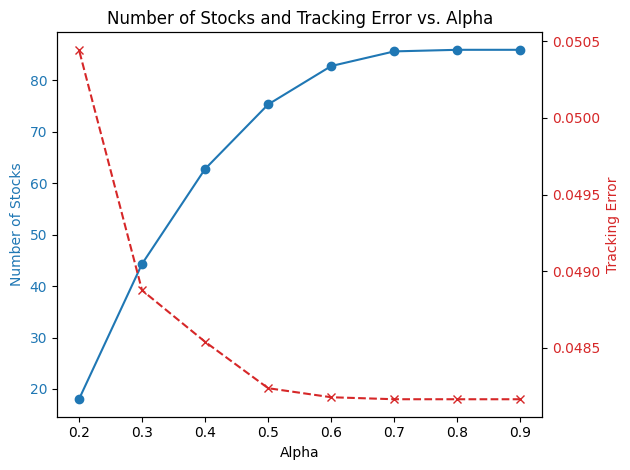

In [29]:
Corr_Lasso_plot(X,y)

----------Starting alpha 0.001-------------
Train period: 2015-02-02 10:19:00 to 2015-08-25 14:20:00
Test period: 2015-08-25 14:21:00 to 2016-04-07 11:40:00
Selected 70 stocks
Best Alpha for this fold: 0.0001, Best Fold Score: 0.04757327527243649
Train period: 2015-02-19 15:12:00 to 2016-04-07 11:40:00
Test period: 2016-04-07 11:41:00 to 2016-10-18 12:52:00
Selected 72 stocks
Best Alpha for this fold: 0.0001, Best Fold Score: 0.035880639079479804
Train period: 2015-09-29 11:53:00 to 2016-10-18 12:52:00
Test period: 2016-10-18 12:53:00 to 2017-05-02 12:41:00
Selected 76 stocks
Best Alpha for this fold: 0.0001, Best Fold Score: 0.043346668200988536
Train period: 2016-04-29 14:28:00 to 2017-05-02 12:41:00
Test period: 2017-05-02 12:42:00 to 2017-11-10 11:24:00
Selected 78 stocks
Best Alpha for this fold: 0.0001, Best Fold Score: 0.027371671944238556
Train period: 2016-11-07 14:17:00 to 2017-11-10 11:24:00
Test period: 2017-11-10 11:25:00 to 2018-05-24 10:55:00
Selected 76 stocks
Best Alph

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.647e-01, tolerance: 8.593e-02
  model = cd_fast.enet_coordinate_descent(


Selected 80 stocks
Best Alpha for this fold: 0.0001, Best Fold Score: 0.04667040117914395
Train period: 2020-03-12 11:54:00 to 2021-03-16 09:33:00
Test period: 2021-03-16 09:34:00 to 2021-09-28 14:42:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.302e-01, tolerance: 8.393e-02
  model = cd_fast.enet_coordinate_descent(


Selected 81 stocks
Best Alpha for this fold: 0.0001, Best Fold Score: 0.03690028475098253
Train period: 2020-09-28 10:52:00 to 2021-09-28 14:42:00
Test period: 2021-09-28 14:43:00 to 2022-04-12 10:57:00
Selected 81 stocks
Best Alpha for this fold: 0.0001, Best Fold Score: 0.051603177392449136
Train period: 2021-04-12 11:55:00 to 2022-04-12 10:57:00
Test period: 2022-04-12 10:58:00 to 2022-10-24 19:14:00
Selected 79 stocks
Best Alpha for this fold: 0.0001, Best Fold Score: 0.05020158494112576
Alpha: 0.001, Average Tracking Error: 0.04742580986337261
----------Starting alpha 0.002-------------
Train period: 2015-02-02 10:19:00 to 2015-08-25 14:20:00
Test period: 2015-08-25 14:21:00 to 2016-04-07 11:40:00
Selected 57 stocks
Best Alpha for this fold: 0.0001, Best Fold Score: 0.04776546826460951
Train period: 2015-02-19 15:12:00 to 2016-04-07 11:40:00
Test period: 2016-04-07 11:41:00 to 2016-10-18 12:52:00
Selected 58 stocks
Best Alpha for this fold: 0.0001, Best Fold Score: 0.0359797312035

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.081e-01, tolerance: 8.593e-02
  model = cd_fast.enet_coordinate_descent(


Selected 78 stocks
Best Alpha for this fold: 0.0001, Best Fold Score: 0.04667402305322088
Train period: 2020-03-12 11:54:00 to 2021-03-16 09:33:00
Test period: 2021-03-16 09:34:00 to 2021-09-28 14:42:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.758e-01, tolerance: 8.393e-02
  model = cd_fast.enet_coordinate_descent(


Selected 77 stocks
Best Alpha for this fold: 0.0001, Best Fold Score: 0.03692992713374181
Train period: 2020-09-28 10:52:00 to 2021-09-28 14:42:00
Test period: 2021-09-28 14:43:00 to 2022-04-12 10:57:00
Selected 69 stocks
Best Alpha for this fold: 0.0001, Best Fold Score: 0.051635628024536376
Train period: 2021-04-12 11:55:00 to 2022-04-12 10:57:00
Test period: 2022-04-12 10:58:00 to 2022-10-24 19:14:00
Selected 72 stocks
Best Alpha for this fold: 0.0001, Best Fold Score: 0.05022234498769072
Alpha: 0.002, Average Tracking Error: 0.04748442563819904
----------Starting alpha 0.003-------------
Train period: 2015-02-02 10:19:00 to 2015-08-25 14:20:00
Test period: 2015-08-25 14:21:00 to 2016-04-07 11:40:00
Selected 52 stocks
Best Alpha for this fold: 0.0001, Best Fold Score: 0.04783079662342577
Train period: 2015-02-19 15:12:00 to 2016-04-07 11:40:00
Test period: 2016-04-07 11:41:00 to 2016-10-18 12:52:00
Selected 52 stocks
Best Alpha for this fold: 0.0001, Best Fold Score: 0.0360342483143

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.741e-01, tolerance: 8.593e-02
  model = cd_fast.enet_coordinate_descent(


Selected 74 stocks
Best Alpha for this fold: 0.0001, Best Fold Score: 0.046699310187424146
Train period: 2020-03-12 11:54:00 to 2021-03-16 09:33:00
Test period: 2021-03-16 09:34:00 to 2021-09-28 14:42:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.175e-01, tolerance: 8.393e-02
  model = cd_fast.enet_coordinate_descent(


Selected 73 stocks
Best Alpha for this fold: 0.0001, Best Fold Score: 0.036941773492465795
Train period: 2020-09-28 10:52:00 to 2021-09-28 14:42:00
Test period: 2021-09-28 14:43:00 to 2022-04-12 10:57:00
Selected 60 stocks
Best Alpha for this fold: 0.0001, Best Fold Score: 0.0516570483413082
Train period: 2021-04-12 11:55:00 to 2022-04-12 10:57:00
Test period: 2022-04-12 10:58:00 to 2022-10-24 19:14:00
Selected 58 stocks
Best Alpha for this fold: 0.0001, Best Fold Score: 0.05025730966610247
Alpha: 0.003, Average Tracking Error: 0.04754612856889649
----------Starting alpha 0.004-------------
Train period: 2015-02-02 10:19:00 to 2015-08-25 14:20:00
Test period: 2015-08-25 14:21:00 to 2016-04-07 11:40:00
Selected 44 stocks
Best Alpha for this fold: 0.0001, Best Fold Score: 0.047955160179843616
Train period: 2015-02-19 15:12:00 to 2016-04-07 11:40:00
Test period: 2016-04-07 11:41:00 to 2016-10-18 12:52:00
Selected 49 stocks
Best Alpha for this fold: 0.0001, Best Fold Score: 0.0360456146421

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.244e-01, tolerance: 8.593e-02
  model = cd_fast.enet_coordinate_descent(


Selected 66 stocks
Best Alpha for this fold: 0.0001, Best Fold Score: 0.046711417967603204
Train period: 2020-03-12 11:54:00 to 2021-03-16 09:33:00
Test period: 2021-03-16 09:34:00 to 2021-09-28 14:42:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.306e-01, tolerance: 8.393e-02
  model = cd_fast.enet_coordinate_descent(


Selected 69 stocks
Best Alpha for this fold: 0.0001, Best Fold Score: 0.03695230472016438
Train period: 2020-09-28 10:52:00 to 2021-09-28 14:42:00
Test period: 2021-09-28 14:43:00 to 2022-04-12 10:57:00
Selected 54 stocks
Best Alpha for this fold: 0.0001, Best Fold Score: 0.05168352591239511
Train period: 2021-04-12 11:55:00 to 2022-04-12 10:57:00
Test period: 2022-04-12 10:58:00 to 2022-10-24 19:14:00
Selected 52 stocks
Best Alpha for this fold: 0.0001, Best Fold Score: 0.05027888129315549
Alpha: 0.004, Average Tracking Error: 0.04761680641297684
----------Starting alpha 0.005-------------
Train period: 2015-02-02 10:19:00 to 2015-08-25 14:20:00
Test period: 2015-08-25 14:21:00 to 2016-04-07 11:40:00
Selected 41 stocks
Best Alpha for this fold: 0.0001, Best Fold Score: 0.048012472367989376
Train period: 2015-02-19 15:12:00 to 2016-04-07 11:40:00
Test period: 2016-04-07 11:41:00 to 2016-10-18 12:52:00
Selected 43 stocks
Best Alpha for this fold: 0.0001, Best Fold Score: 0.0360636631171

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.885e-01, tolerance: 8.593e-02
  model = cd_fast.enet_coordinate_descent(


Selected 60 stocks
Best Alpha for this fold: 0.0001, Best Fold Score: 0.04673099392087022
Train period: 2020-03-12 11:54:00 to 2021-03-16 09:33:00
Test period: 2021-03-16 09:34:00 to 2021-09-28 14:42:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.973e-01, tolerance: 8.393e-02
  model = cd_fast.enet_coordinate_descent(


Selected 62 stocks
Best Alpha for this fold: 0.0001, Best Fold Score: 0.03697537962177761
Train period: 2020-09-28 10:52:00 to 2021-09-28 14:42:00
Test period: 2021-09-28 14:43:00 to 2022-04-12 10:57:00
Selected 46 stocks
Best Alpha for this fold: 0.0001, Best Fold Score: 0.05170811910494671
Train period: 2021-04-12 11:55:00 to 2022-04-12 10:57:00
Test period: 2022-04-12 10:58:00 to 2022-10-24 19:14:00
Selected 45 stocks
Best Alpha for this fold: 0.0001, Best Fold Score: 0.050282910620942416
Alpha: 0.005, Average Tracking Error: 0.047665396398025243
----------Starting alpha 0.006-------------
Train period: 2015-02-02 10:19:00 to 2015-08-25 14:20:00
Test period: 2015-08-25 14:21:00 to 2016-04-07 11:40:00
Selected 36 stocks
Best Alpha for this fold: 0.0001, Best Fold Score: 0.048067031835883386
Train period: 2015-02-19 15:12:00 to 2016-04-07 11:40:00
Test period: 2016-04-07 11:41:00 to 2016-10-18 12:52:00
Selected 40 stocks
Best Alpha for this fold: 0.0001, Best Fold Score: 0.03608426723

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.228e-01, tolerance: 8.593e-02
  model = cd_fast.enet_coordinate_descent(


Selected 55 stocks
Best Alpha for this fold: 0.0001, Best Fold Score: 0.04676650965822674
Train period: 2020-03-12 11:54:00 to 2021-03-16 09:33:00
Test period: 2021-03-16 09:34:00 to 2021-09-28 14:42:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.092e-01, tolerance: 8.393e-02
  model = cd_fast.enet_coordinate_descent(


Selected 55 stocks
Best Alpha for this fold: 0.0001, Best Fold Score: 0.03703545298640226
Train period: 2020-09-28 10:52:00 to 2021-09-28 14:42:00
Test period: 2021-09-28 14:43:00 to 2022-04-12 10:57:00
Selected 36 stocks
Best Alpha for this fold: 0.0001, Best Fold Score: 0.0517360443477266
Train period: 2021-04-12 11:55:00 to 2022-04-12 10:57:00
Test period: 2022-04-12 10:58:00 to 2022-10-24 19:14:00
Selected 39 stocks
Best Alpha for this fold: 0.0001, Best Fold Score: 0.050338523380531984
Alpha: 0.006, Average Tracking Error: 0.047724662621038035
----------Starting alpha 0.007-------------
Train period: 2015-02-02 10:19:00 to 2015-08-25 14:20:00
Test period: 2015-08-25 14:21:00 to 2016-04-07 11:40:00
Selected 33 stocks
Best Alpha for this fold: 0.0001, Best Fold Score: 0.04809380168014003
Train period: 2015-02-19 15:12:00 to 2016-04-07 11:40:00
Test period: 2016-04-07 11:41:00 to 2016-10-18 12:52:00
Selected 35 stocks
Best Alpha for this fold: 0.0001, Best Fold Score: 0.0361445762236

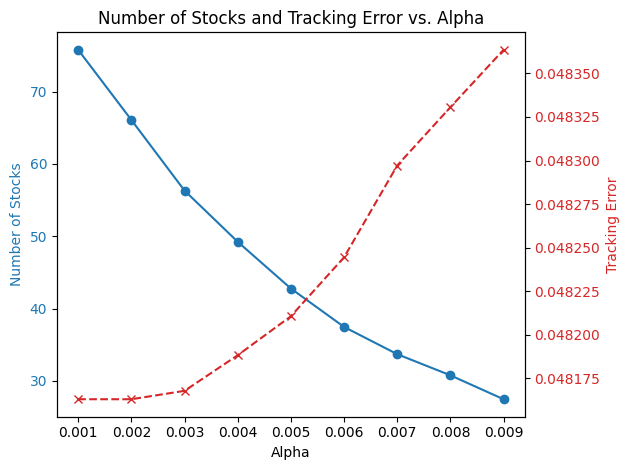

In [30]:
Lasso_Lasso_plot(X,y)

Starting percentile: 0.0
Percentile: 0.0, Tracking Error: 0.04740712818342317, Adj Tracking Error: 0.04740712895294234
Starting percentile: 0.1
Percentile: 0.1, Tracking Error: 0.04742070285193751, Adj Tracking Error: 0.047420703614115774
Starting percentile: 0.2
Percentile: 0.2, Tracking Error: 0.04744607856276448, Adj Tracking Error: 0.047446079320729855
Starting percentile: 0.3
Percentile: 0.3, Tracking Error: 0.04749179663664328, Adj Tracking Error: 0.04749179738461939
Starting percentile: 0.4
Percentile: 0.4, Tracking Error: 0.047512787916759246, Adj Tracking Error: 0.0475127886221998
Starting percentile: 0.5
Percentile: 0.5, Tracking Error: 0.04752696846883527, Adj Tracking Error: 0.04752696914083453
Starting percentile: 0.6
Percentile: 0.6, Tracking Error: 0.04764621757882751, Adj Tracking Error: 0.04764621820133552


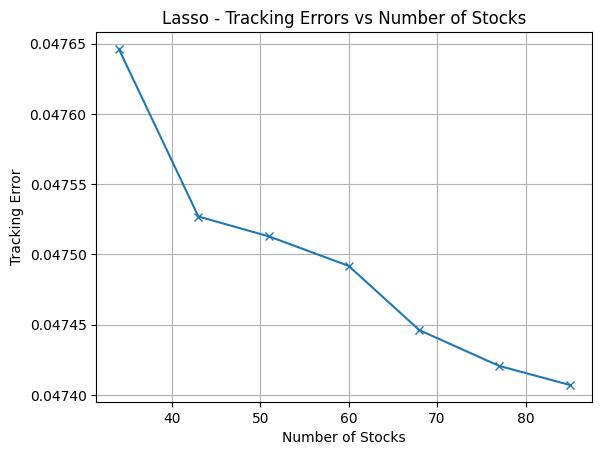

In [31]:
MI_Lasso_plot(X,y)

Starting percentile: 0.0
Percentile: 0.0, Tracking Error: 0.04737310293178804, Adj Tracking Error: 0.04737310370978785
Starting percentile: 0.1
Percentile: 0.1, Tracking Error: 0.047390166127283834, Adj Tracking Error: 0.04739016689820787
Starting percentile: 0.2
Percentile: 0.2, Tracking Error: 0.04741759150368855, Adj Tracking Error: 0.04741759226825459
Starting percentile: 0.3
Percentile: 0.3, Tracking Error: 0.04746501912735405, Adj Tracking Error: 0.047465019881770806
Starting percentile: 0.4
Percentile: 0.4, Tracking Error: 0.0474787405669045, Adj Tracking Error: 0.04747874127702338
Starting percentile: 0.5
Percentile: 0.5, Tracking Error: 0.04750185969991523, Adj Tracking Error: 0.047501860376180885
Starting percentile: 0.6
Percentile: 0.6, Tracking Error: 0.047622437861658456, Adj Tracking Error: 0.047622438496416154


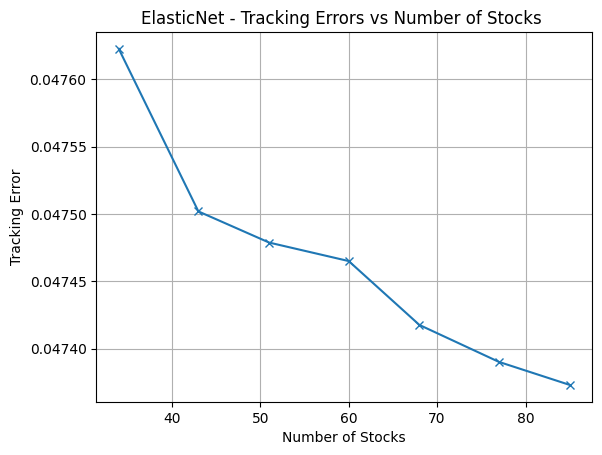

In [32]:
MI_ElasticNet_plot(X,y)

Starting percentile: 0.1
Percentile: 0.1, Tracking Error: 0.04651718379268318, Adj Tracking Error: 0.04651718378531212
Starting percentile: 0.2
Percentile: 0.2, Tracking Error: 0.04661108159498296, Adj Tracking Error: 0.0466110830663835
Starting percentile: 0.3
Percentile: 0.3, Tracking Error: 0.046680878230779425, Adj Tracking Error: 0.046680879480528806
Starting percentile: 0.4
Percentile: 0.4, Tracking Error: 0.046713685975876565, Adj Tracking Error: 0.046713686619116235
Starting percentile: 0.5
Percentile: 0.5, Tracking Error: 0.04676255761531885, Adj Tracking Error: 0.04676255808626659
Starting percentile: 0.6
Percentile: 0.6, Tracking Error: 0.04689748036334755, Adj Tracking Error: 0.046897481755996694
Starting percentile: 0.7
Percentile: 0.7, Tracking Error: 0.047122484599968435, Adj Tracking Error: 0.04712248499800715
Starting percentile: 0.8
Percentile: 0.8, Tracking Error: 0.04721128986814528, Adj Tracking Error: 0.04721129236080135


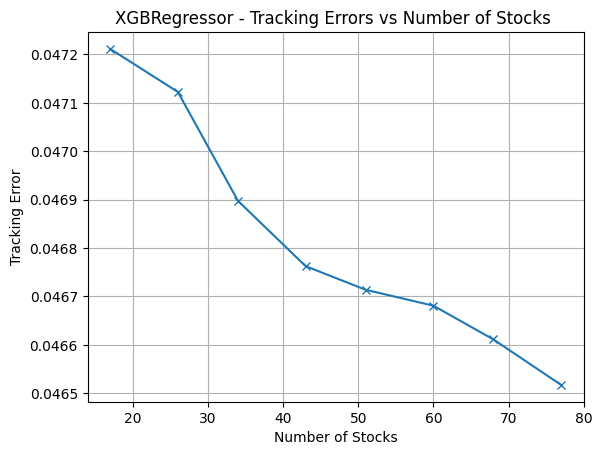

In [33]:
MI_XGBoost_plot(X,y)